## CMPE 462 HOMEWORK 3

In [4]:
# Allowed Libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Multilayered Perceptron
**Target:** Implement multi-layer perceptron and analyze the results

**Data:**  The dataset (points2d.dat) is attached to the email. The sample includes 400 instances. Each instance is represented by a feature vector of 2 dimensions. The third column corresponds to the class (0/1/2) of the instance.

- Report how you split the sample for training and test. Report how you designed your neural network to solve this 3-class problem.(number of layers, error function etc.)
- Derive weight update equations using hyperbolic tangent activation function for hidden layers and sigmoid activation function for output layer . Submit a hard-copy of this derivation, drawing the the corresponding neural network with hidden units. All the formulas and the corresponding symbols should be clear. 
- Implement multi-layer perceptron with 5 hidden units. While training at each iteration, plot the error on training and test sets.
- After training converges: Plot the validation/test set and show true positives, true negatives,false positives, and false negatives (with different markers, colors, etc.)

Total: 400, Training: 240, Validation: 80, Test: 80 


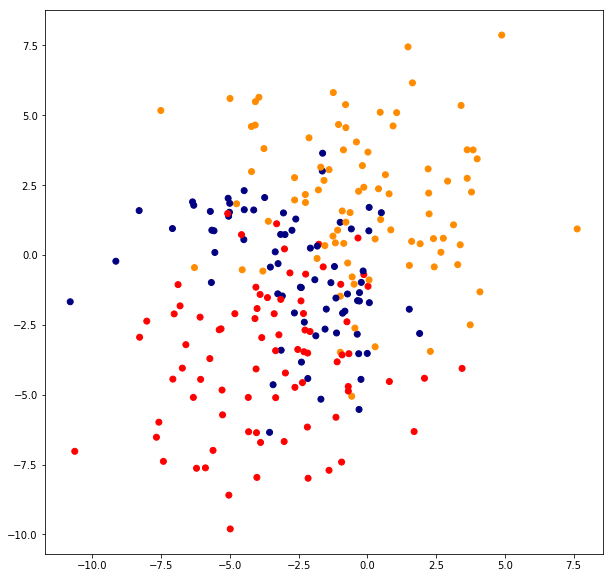

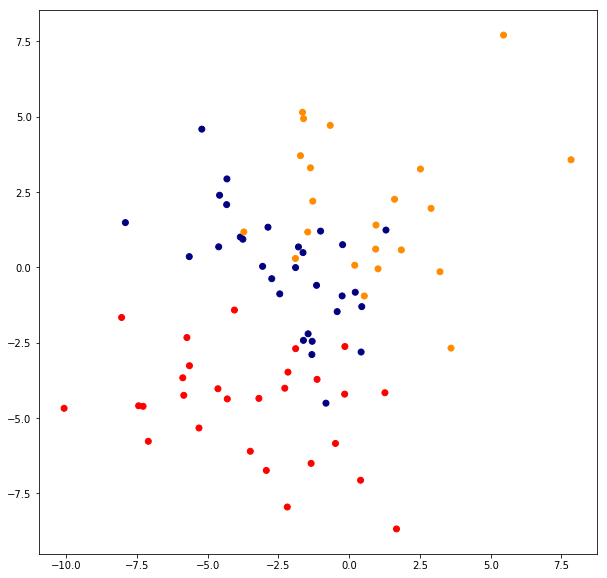

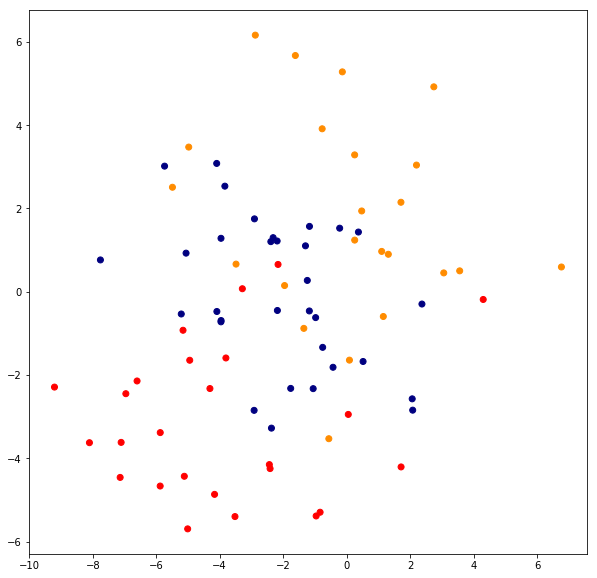

In [10]:
percentages = [60,20,20]
LIKELIHOOD_THRESHOLD = 1e-2

COLORS = ['darkorange','navy','red']
def read_data():
    data = []
    with open('points2d.dat') as fp:
        for line in fp:
            raw = line.split()
            converted = [float(raw[0]),float(raw[1]),int(raw[2])]
            data.append(converted)
    return np.array(data)

def split_data(data):
    first_seperator = (int)(percentages[0]*len(data)/100.0)
    second_seperator = (int)((percentages[0]+percentages[1])*len(data)/100.0)
    
    training_data = data[0:first_seperator]
    validation_data = data[first_seperator:second_seperator]
    test_data = data[second_seperator:]
    
    return training_data,validation_data,test_data

def plot_data(data):
    fig, axs = plt.subplots(1, figsize=(10, 10))
    axs.scatter(data[:,0], data[:,1], c=data[:,2], cmap=matplotlib.colors.ListedColormap(COLORS))
    plt.show()

data = read_data()
training, validation, test = split_data(data)

print("Total: %s, Training: %s, Validation: %s, Test: %s " %(len(data),len(training),len(validation),len(test)))

plot_data(training)
plot_data(validation)
plot_data(test)